In [2]:
import os
from os import listdir
import math

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as TransForms


test image shape : (67, 26, 3)


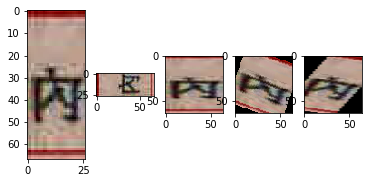

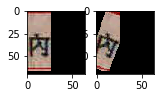

In [49]:
'''
custom dataset transform = None or not
data augmentation with Rotate or not, with 'padding' data
because，the height is fixed = 67, width range is 3~512, if used resize , the data maybe change more

自定義 dataset class 是否使用 transform
取決於是否使用資料擴增 ，在訓練資料增加 旋轉的Data ，主要對於padding data
因為，高度固定是67，寬度則不一致，直接使用 resize 則原本的字體會改變太多，變寬或變窄

如下圖 先resize後再做旋轉的圖片，看似比較好


follow sampling ，input data height always=67 and gpu not enough storage ,that use size is '64x64'
for the example , more better with resize -> rotate

#所以對於原始圖片+擴增圖片的部分，會先讓擴增圖片先進行resize後再做旋轉#
#對於原始圖片則是 width < 64 used padding , width > 64 則使用resize
'''
resize_shape = 64
trans = TransForms.Compose([TransForms.Resize((resize_shape,resize_shape))])
img_path = os.getcwd() + '/image/test_show01.jpg'
img = Image.open(img_path)

#
plt.figure(figsize=(6, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    if i==0:
        plt.imshow(img)
    elif i == 1:
        img_rotate = img.transpose(Image.ROTATE_90)
        plt.imshow(img_rotate)
    elif i == 2:
        img_resize = trans(img)
        plt.imshow(img_resize)
    elif i==3 :
        img_rotate_20 = trans(img).rotate(-20) # first resize ,and then rotate
        plt.imshow(img_rotate_20)
    else:
        img_rotate_20_resize = trans(img.rotate(-20)) # first rotate ,and then resize
        plt.imshow(img_rotate_20_resize)

# padding data
print('test image shape :', (np.array(img)).shape) # [height, width, channels]

padding = (0, 0, 64-(np.array(img)).shape[1], (np.array(img)).shape[0]-64) # left, up, right, down (添加padding方向 , 可以負的)
trans_pad = TransForms.Compose([TransForms.Pad(padding, fill = 0, padding_mode ="constant")])
plt.figure(figsize=(6, 10))
plt.subplot(1, 5, 1)
plt.imshow(trans_pad(img))
plt.subplot(1, 5, 2)
plt.imshow(trans_pad(img.rotate(-20))) # it could find the 0 num. too many

In [162]:
### before start , please check image_table.csv
### Ref: https://chih-sheng-huang821.medium.com/03-pytorch-dataaug-a712a7a7f55e

# output [1] same shape
class MyDataset01(torch.utils.data.Dataset):
    def __init__(self, root, tab_file = 'basic_image_tab.csv', transform = None, train = True, scale = 0.8, 
                 IsAug = None, shape = (64, 64), pad_module = ['center', 'center']):
        super().__init__()
        '''
        parameter:
            root : .csv file root
            tab_file : image info. on csv
            transform : if not None , maybe using 
            train : using training set or validation set
            scale : numble of training set on dataset
            IsAug : Using Augumentation Data , only train == True
            shape : change Image size for what
            pad_module: padding direction , ex: set 'Center' padding/change size around image
            
            
            padding module used cut height if resize h < ground truth h ex: resize_h = 64 , 
            gt_h = 64 ,cut where? top or bottom, input [h_direction, w_direction] ,ex:[center, left]
        '''
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        imgs = df['img_name'].values.tolist()
        labels = df['img_token'].values.tolist()
        
        self.imgs = imgs
        self.labels = labels
        
        self.root = os.path.join(root, 'train_data', 'training_set')
        self.train = train
        self.transform = transform
        self.IsAug = IsAug
        self.height, self.width = shape
        self.pad_module = pad_module
        
        self.count = int(len(self.imgs)*scale)
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
            
    
    def __getitem__(self, index):
        
        if self.IsAug != None :
            # only augumentation training_data
            if self.train == True:
                trans = torchvision.transforms.Compose([torchvision.transforms.Resize((self.height, self.width))])
                img_path = os.path.join(self.root , self.imgs[index])
                img = Image.open(img_path)
                img = trans(img)
                
                label = self.labels[index]
                
                if self.IsAug == 'Rotate90':
                    img = img.transpose(Image.ROTATE_90)
                elif self.IsAug == 'Rotate180':
                    img = img.transpose(Image.ROTATE_180)
                elif self.IsAug == 'Rotate270':
                    img = img.transpose(Image.ROTATE_270)
                elif self.IsAug == 'Rotate_pos_20':
                    img = img.rotate(-20) #順時
                elif self.IsAug == 'Rotate_neg_20':
                        img = img.rotate(20)
                else:
                    raise ValueError('>>If want to using Aug_Data, follow specified param. or new one')
            
                trans_toTensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
                img = trans_toTensor(img)
                
                return img, label
            else:
                raise ValueError('>>Get Dataset Error : If used Augumentation data, please check \'train=True\'. ')
        # ============
        else:
            
            if self.train == True:
                img_path = os.path.join(self.root , self.imgs[index])
                img = Image.open(img_path)
                label = self.labels[index]
            else:
                img_path = os.path.join(self.root , self.imgs[self.count+index])
                img = Image.open(img_path)
                label = self.labels[self.count+index]
                
            gt_height , gt_width = np.array(img).shape[0], np.array(img).shape[1] # ground truth
            
            if gt_width > self.width:
                trans = torchvision.transforms.Compose([torchvision.transforms.Resize((self.height, self.width))])
                img = trans(img)
            else:
                add_h = self.height - gt_height
                add_w = self.width - gt_width
                
                # padding = (add_left, add_top, add_right, add_bottom)
                if self.pad_module[0] == 'center':
                    if add_h % 2 == 0:
                        add_top = add_h//2
                        add_bottom = add_h//2
                    else:
                        add_top = add_h//2
                        add_bottom = add_h//2 + 1
                elif self.pad_module[0] == 'top':
                    add_top = add_h
                else:
                    add_bottom = add_h
                    
                if self.pad_module[1] == 'center':
                    if add_w % 2 == 0:
                        add_left = add_w//2
                        add_right = add_w//2
                    else:
                        add_left = add_w//2
                        add_right = add_w//2+1
                elif self.pad_module[1] == 'left':
                    add_left = add_w
                else:
                    add_right = add_w
                    
                padding = (add_left, add_top, add_right, add_bottom)
                trans_pad = torchvision.transforms.Compose([torchvision.transforms.Pad(padding, 
                                                                                       fill = 0, padding_mode="constant")])
                img = trans_pad(img)
            trans_toTensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
            img = trans_toTensor(img)
            
            return img, label
        
if __name__ == '__main__':
    
    root = os.getcwd()
# example general train_data
    train_data = MyDataset01(root)
    print('train_data :', len(train_data))


train_data : 55043


train_data : 55043
55037
55038
55039
55040
55041
55042


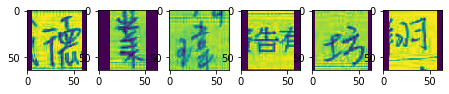

In [126]:

if __name__ == '__main__':
    
    root = os.getcwd()
# example general train_data
    train_data = MyDataset01(root )
    print('train_data :', len(train_data))
    index = 0
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=False)
    
    plt.figure(figsize=(10, 10))
    for i, (data, label) in enumerate(train_loader):
        if i > (55043-7):
            print(i)
            plt.subplot(1, 8, index+1)
            plt.imshow(data[0,0,:,:])
            index += 1  

test_data : 55043


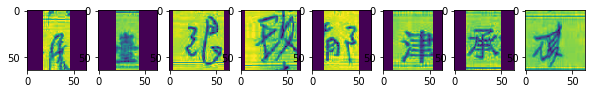

In [178]:
if __name__ == '__main__':
    
    root = os.getcwd()
    train_data = MyDataset01(root , train=False)
    print('test_data :', len(test_data))
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=False)
    plt.figure(figsize=(10, 10))
    for i, (data, label) in enumerate(train_loader):

        plt.subplot(1, 8, i+1)
        plt.imshow(data[0,0,:,:])
        if i == 7:
            break

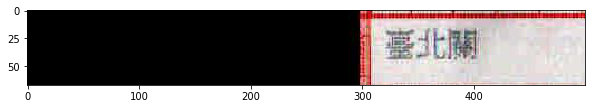

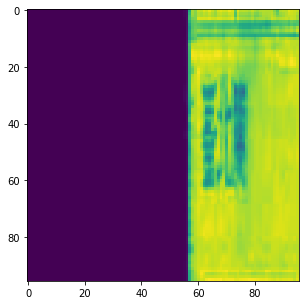

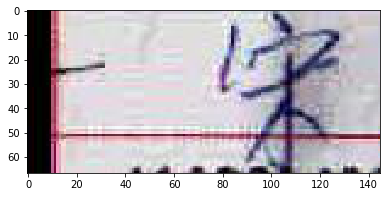

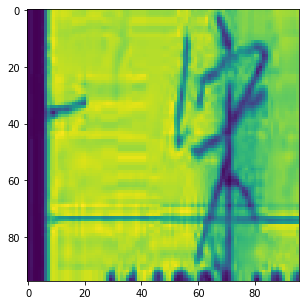

In [157]:
# 可以看到有超過指定shape大小的寬度 for example: 500 > specified shape 64、96...32xn
# 如下圖44 超出並且多個中字擺一起，並非單一中文字，則變得無法識別
if __name__ == '__main__':
    
    ovre_shape_path_ex ='/train_data/training_set/00043_臺.jpg'
    img = Image.open(os.getcwd() + ovre_shape_path_ex)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    
    training_set = MyDataset01(os.getcwd() , shape = (96, 96))
    #
    data , label = training_set[43]
    plt.figure(figsize=(5, 5))
    plt.imshow(data[0,:,:])
    #
    
    ovre_shape_path_ex ='/train_data/training_set/58777_宋.jpg'
    img = Image.open(os.getcwd() + ovre_shape_path_ex)
    plt.figure(figsize=(10, 3))
    plt.imshow(img)
    
    data , label = training_set[58777]
    plt.figure(figsize=(5, 5))
    plt.imshow(data[0,:,:])
    #

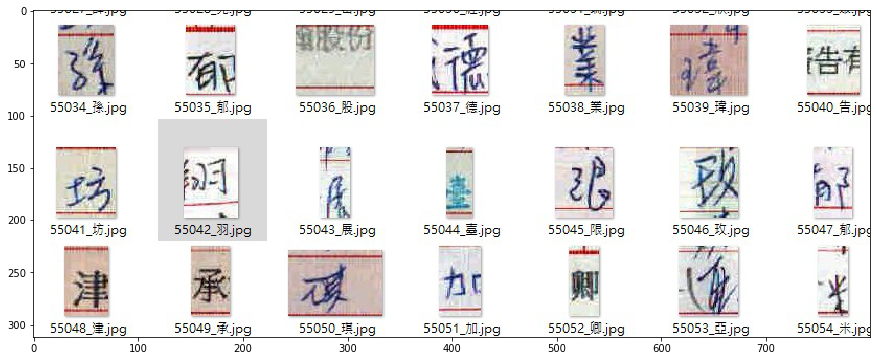

In [129]:
# 證明是否取值有誤 ,如下圖
prove_img = os.getcwd() + '/image/MyDataset01_01.jpg'
img = Image.open(prove_img)
plt.figure(figsize=(15, 15))
plt.imshow(img) # 55042 的下一個 55043 符合上面所示 ,the data split is correct

test_data : 55043


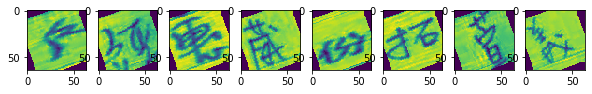

In [177]:
# 顯示augumentation data
# example augumentation data


if __name__ == '__main__':
    
    root = os.getcwd()
    sample_data01 = MyDataset01(root , train=True, IsAug = 'Rotate_neg_20')
    print('test_data :', len(sample_data01))
    train_loader = torch.utils.data.DataLoader(dataset=sample_data01, batch_size=1, shuffle=False)
    plt.figure(figsize=(10, 10))
    for i, (data, label) in enumerate(train_loader):

        plt.subplot(1, 8, i+1)
        plt.imshow(data[0,0,:,:])
        if i == 7:
            break
            

In [165]:
# concat data example
train = MyDataset01(root = os.getcwd())
aug = MyDataset01(root , train=True, IsAug = 'Rotate_neg_20')
concat_data = torch.utils.data.ConcatDataset([train, aug])
print(len(concat_data))

110086


In [176]:
# output [2] different shape
class MyDataset02(torch.utils.data.Dataset):
    def __init__(self, root, tab_file = 'basic_image_tab.csv', transforms = None, train = True, scale = 0.8):
        super().__init__()
        '''
        
        '''
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        img_lst = df['img_name'].values.tolist()
        label_lst = df['img_token'].values.tolist()
        
        self.root = os.path.join(root, 'train_data', 'training_set')
        self.transforms = transforms
        self.train = train
        
        self.imgs = img_lst
        self.labels = label_lst
        self.count = int(len(self.imgs)*scale)
        
        
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
        
    def __getitem__(self, index):
        
        if self.train == True:
            img_path = os.path.join(self.root , self.imgs[index])
            img = Image.open(img_path)
            label = self.labels[index]
        else:
            img_path = os.path.join(self.root , self.imgs[self.count+index])
            img = Image.open(img_path)
            label = self.labels[self.count+index]
            
        if self.transforms != None:
            img = self.transforms(img)
            
        return img, label
    # !!!!!!!!!!!!!!!!!! 透過自定義(custom)方式做batch
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

# sample othe method to resize
def Resize_with_bilinear(image, shape = (64, 64)):
    return nn.functional.interpolate(image.unsqueeze(0), shape, mode = 'bilinear', align_corners=True)
    
if __name__ == '__main__':
    data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    train_data_set = MyDataset02(root = os.getcwd(), transforms = data_transform)
    print(len(train_data_set))
    data_loader = torch.utils.data.DataLoader(dataset = train_data_set,
                                             batch_size = 4,
                                             shuffle = False,
                                             collate_fn = train_data_set.collate_fn) 
    for i, (data, label) in enumerate(data_loader):
        for sample in data:
            print(sample.size())# 如打印 一個batch內的size 不同
            print('>> Using interpolate func. :', Resize_with_bilinear(sample).size()) # after this step, usinig concat
        break

55043
torch.Size([3, 67, 24])
>> Using interpolate func. : torch.Size([1, 3, 64, 64])
torch.Size([3, 67, 45])
>> Using interpolate func. : torch.Size([1, 3, 64, 64])
torch.Size([3, 67, 33])
>> Using interpolate func. : torch.Size([1, 3, 64, 64])
torch.Size([3, 67, 73])
>> Using interpolate func. : torch.Size([1, 3, 64, 64])
